# Regression Diagnostics in Statsmodels

## Introduction

So far, you have looked mainly at R-Squared values along with some visualization techniques to confirm that regression assumptions are met. Now, you'll look at some statistical procedures to further understand your model and results. You'll be looking at the results obtained in the regression analysis outcomes for the advertising dataset in the previous lab. 

*Note: Some of the terms in this lesson highlighting underlying statistical testing concepts will be new to you. These terms will be covered in detail in later sections. Here, the focus will be on running and interpreting the results of these tests in a regression context.*

## Objectives

You will be able to:
* Determine if a particular set of data exhibits the assumptions of linear regression

## Let's get started

Regression diagnostics is a set of procedures available for regression analysis that assess the validity of a model in a number of different ways. 

This could be:
- An exploration of the model's underlying statistical assumptions
- An examination of the structure of the model by considering formulations that have less, more or different explanatory variables
- A study of subgroups of observations, looking for those that are either poorly represented by the model (outliers) or that have a relatively large effect on the regression model's predictions

For a thorough overview, you can go and have a look at the [wikipedia page on regression diagnostics.](https://en.wikipedia.org/wiki/Regression_diagnostic)

Here we'll revisit some of the methods you've already seen, along with some new tests and how to interpret them. 

## Normality Check (Q-Q plots) 
You've already seen Q-Q Plots as a measure to check for normality (or, by extension, any other distribution). 

Q-Q plots are also referred to as normal density plots when used with standard normal quantiles. These plots are a good way to inspect the distribution of model errors. You saw this earlier with the small height-weight data set. Let's quickly generate a Q-Q plot for the residuals in the `sales ~ TV` and the `sales ~ radio` models again!

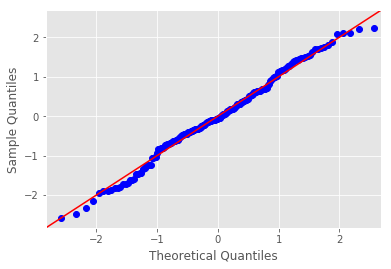

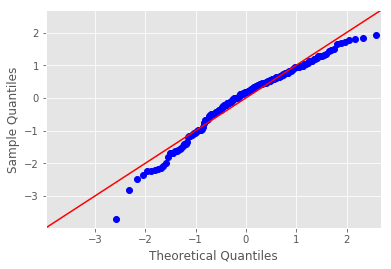

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('ggplot')

data = pd.read_csv('advertising.csv', index_col=0)
f = 'sales~TV'
f2 = 'sales~radio'
model = smf.ols(formula=f, data=data).fit()
model2 = smf.ols(formula=f2, data=data).fit()

resid1 = model.resid
resid2 = model2.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)

Normal Q-Q Plots are a direct visual assessment of how well our residuals match what we would expect from a normal distribution. 

In the Q-Q plots above, you can see that residuals are better normally distributed for TV than for radio. 

You can also spot an outlier in the left tail of radio residuals. Dealing with this might help improve the fit of the model. Outliers, skew, heavy and light-tailed aspects of distributions (all violations of normality) can be assessed from Q-Q plots. It might require a bit of practice before you can truly start to interpret them. 

The images below show you how to relate a histogram to their respective Q-Q Plots.

![](images/inhouse_qq_density.png)

## Normality Check (Jarque-Bera Test)

The Jarque-Bera (JB) test is a test for normality. This test is usually used for large data sets, because other tests like Q-Q Plots can become unreliable when your sample size is large.

>The Jarque-Bera test inspects the skewness and kurtosis of data to see if it matches a normal distribution. It is a common method for inspecting errors distribution in regression as shown below. 

$$JB = n *\Bigl(\dfrac{S^2}{6} + \dfrac{(K – 3)^2}{24}\Bigr)$$


Here, $n$ is the sample size, $S$ is the sample skewness coefficient and $K$ is the sample kurtosis.

Here is how you use JB in statsmodels. A JB value of roughly 6 or higher indicates that errors are not normally distributed. In other words, this means that the normality null hypothesis has been rejected at the $5\%$ significance level. A value close to 0 on the contrary, indicates the data $is$ normally distributed. We have already seen the JB test using `model.summary()`. The code below shows you how to run this test on its own.

In [2]:
# JB test for TV
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 0.6688077048615619),
 ('Prob', 0.7157646605518615),
 ('Skew', -0.08863202396577206),
 ('Kurtosis', 2.779014973597054)]

We have a JB value = 0.67, which is pretty low (and in favor of normality), and the p-value of 0.71 is quite high to reject the null hypothesis for normality. Additionally, the kurtosis is below 3, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. The skewness values however show that underlying data is moderately skewed. Let's see what happens if we look at the `radio` residuals.

In [3]:
# JB test for radio
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test2 = sms.jarque_bera(model2.resid)
list(zip(name, test2))

[('Jarque-Bera', 21.90969546280269),
 ('Prob', 1.74731047370758e-05),
 ('Skew', -0.7636952540480038),
 ('Kurtosis', 3.5442808937621666)]

Where The TV residuals showed to be close to normality, the JB results for radio are considerably worse. More-over, a JB p-value much smaller than 0.05 indicates that the normality assumption should definitely be rejected.

These results show that even when in the Q-Q plots the results seemed moderately different, the JB test could shed new light on the normality assumption.

## Checking Heteroscadasticity (Goldfeld-Quandt test)

The Goldfeld Quandt (GQ) test is used in regression analysis to check for homoscedasticity in the error terms. The GQ test checks if you can define a point that can be used to **differentiate** the variance of the error term. It is a parametric test and uses the assumption that the data is normally distributed. So it is general practice to check for normality before going over to the GQ test!


In the image below, you can see how observations are split into two groups. Next, a test statistic is run through taking the ratio of mean square residual errors for the regressions on the two subsets. Evidence of heteroscedasticity is based on performing a hypothesis test (more on this later) as shown in the image.

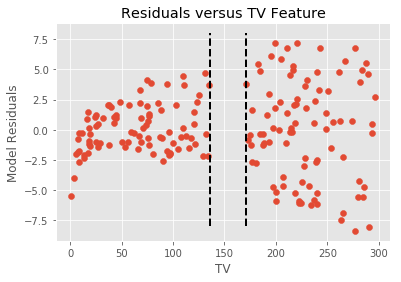

In [4]:
lwr_thresh = data.TV.quantile(q=.45)
upr_thresh = data.TV.quantile(q=.55)
middle_10percent_indices = data[(data.TV >= lwr_thresh) & (data.TV<=upr_thresh)].index
# len(middle_10percent_indices)

indices = [x-1 for x in data.index if x not in middle_10percent_indices]
plt.scatter(data.TV.iloc[indices], model.resid.iloc[indices])
plt.xlabel('TV')
plt.ylabel('Model Residuals')
plt.title("Residuals versus TV Feature")
plt.vlines(lwr_thresh, ymax=8, ymin=-8, linestyles='dashed',linewidth=2)
plt.vlines(upr_thresh, ymax=8, ymin=-8, linestyles='dashed',linewidth=2);

Here is a brief description of the steps involved:

* Order the data in ascending order 
* Split your data into _three_ parts and drop values in the middle part.
* Run separate regression analyses on two parts. After each regression, find the Residual Sum of Squares.
* Calculate the ratio of the Residual sum of squares of two parts.
* Apply the F-test. 

(F-test will be covered later in the syllabus. [Here](https://en.wikipedia.org/wiki/F-test) is a quick introduction)

For now, you should just remember that high F values typically indicate that the variances are different. If the error term is homoscedastic, there should be no systematic difference between residuals and F values will be small.
However, if the standard deviation of the distribution of the error term is proportional to the x variable, one part will generate a higher sum of square values than the other.

Here is how you can run this test in statsmodels. 

In [5]:
# Run Goldfeld Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid.iloc[indices], model.model.exog[indices])
list(zip(name, test))

[('F statistic', 1.1993147096678916), ('p-value', 0.19780602597731686)]

In [6]:
# Run Goldfeld Quandt test
import statsmodels.stats.api as sms
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model2.resid.iloc[indices], model2.model.exog[indices])
list(zip(name, test))

[('F statistic', 1.2189878283402957), ('p-value', 0.1773756718718901)]

The null hypothesis for the GQ test is homoscedasticity. The larger the F-statistic, the more evidence we will have against the homoscedasticity assumption and the more likely we have heteroscedasticity (different variance for the two groups). 

The p-value for our tests above tells us whether or not to reject the null-hypothesis of homoscedasticity. Taking a confidence level of alpha = 0.05, we cannot reject the null hypothesis because for both TV and radio, p-values are larger than 0.05. So even though we visually inspected some heteroscedasticity previously, this cannot be confirmed by the GQ test.

Statsmodel also offers newer tests for heteroscadasticity including the [Breush-Pagan Test](https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.het_breuschpagan.html) and [White’s Test](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_white.html#statsmodels.stats.diagnostic.het_white) which may be advantageous in certain cases.

## Summary 
In this lesson, you learned a few methods to check for regression assumptions in addition to the visual methods learned earlier. An understanding and hands-on experience with visual as well as statistical techniques to check your regression analysis will provide you with a good set of tools to run more detailed regression experiments later. 

In [7]:
print("Fin")

Fin
